# Predicting bike rentals

The aim of the project is to predict the total number of bikes rented per hour, meaning to solve a regression problem.
In light of this, the project will:
- Test different models (DecisionTree, RandomForest, LinearRegression)
- Perform model validation with validation metrics
- Finetune the model with some hyperparameter tuning
- Assess feature importance through permutation importance techniques
- Try to dive into the field of ML interpretability with the usage of [SHAP](https://github.com/slundberg/shap)

--- 

Column description:

	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('hour.csv')
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


# EDA and dataset balance
Start by plotting aggregated hours to check in which timeframe they are most common.

<AxesSubplot:xlabel='hr', ylabel='cnt'>

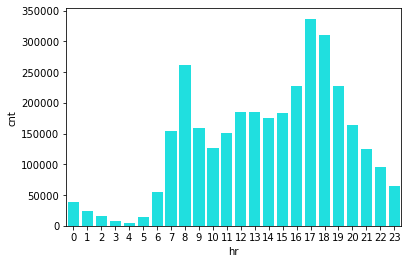

In [4]:
sns.barplot(data=data.groupby(['hr'])['cnt'].sum().to_frame().reset_index()
            , x='hr'
            , y='cnt'
            , color='cyan')

We want to see how many occurencies we have of each hour datapoint: this will be important in the future to understand if we risk underrepresenting certain hours when validating the model and doing train/test operations.

<AxesSubplot:>

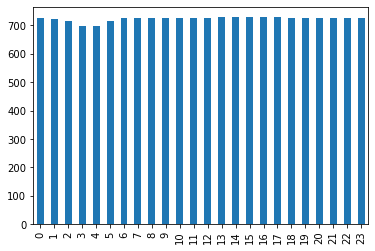

In [5]:
data['hr'].value_counts().sort_index().plot(kind='bar')

Good news! It is a balanced dataset, meaning that when setting aside a test set, we'll not need to rely to more sophisticated methods such as stratified sampling.

In [6]:
data.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

Let's prepare some features to make our life easier for the coming steps.

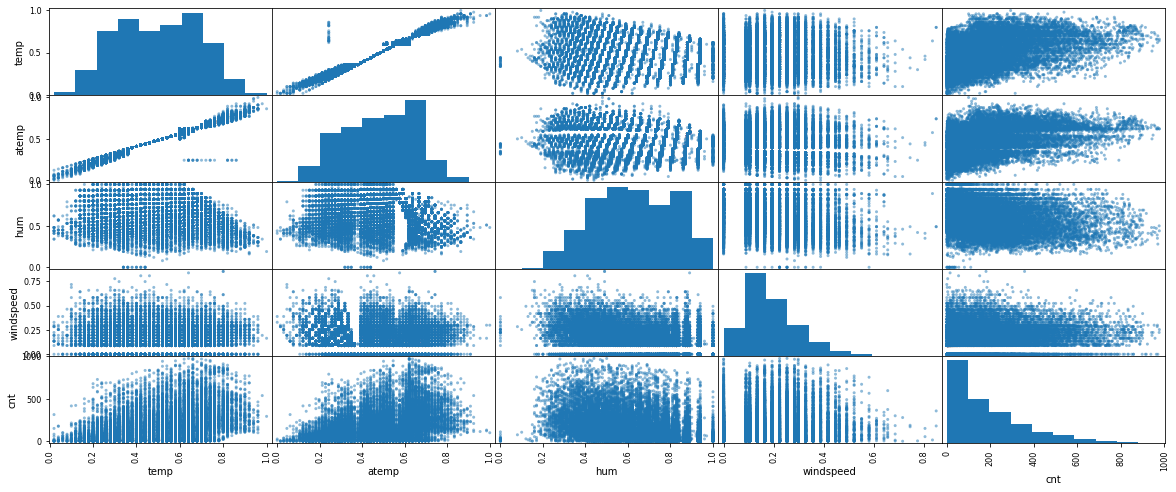

In [7]:
features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
cont_features = ['temp', 'atemp', 'hum', 'windspeed']
target = 'cnt'

pd.plotting.scatter_matrix(data[cont_features + ['cnt']], figsize=(20, 8))
plt.show()

----------
# Approach:
As an approach, we will keep the test set aside, so to avoid ANY data leakage.
This means that we will use a quota of the train set to perform model validation, to be performed with K-fold cross validation.

### iteration 1 - Simple models
- We'll start with a simple prediction with next to no feature engineering. The idea is to get a glimpse of two models (Linear Regression + Random Forest) and how they perform in predicting the target column `cnt`.

### iteration 2 - Feature engineering + simple models
- Feature engineering will include one-hot-encoding of categorical variables and prediction

### iteration 3 - Feature engineering + tuned models
- As iteration 2, but with hyperparameter tuning. 

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
seed = 42

X = data[features]
y = data[target]

# stratified sampling is not needed
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed)

X_train.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
335,1,0,1,11,0,6,0,1,0.20,0.1970,0.55,0.2239
7035,4,0,10,18,0,2,1,1,0.52,0.5000,0.42,0.1045
8051,4,0,12,3,0,3,1,3,0.46,0.4545,1.00,0.2239
2133,2,0,4,18,0,0,0,2,0.46,0.4545,0.31,0.0000
8485,1,0,12,6,0,0,0,1,0.20,0.2273,0.75,0.1045


In [9]:
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor(n_estimators=5, max_depth=10, random_state=seed, criterion='mae')

# fit models
for mod in [lr, dt, rf]:
    mod.fit(X_train, y_train)

In [10]:
# predict and pull together summary statistics
def model_summary_metrics(data, target, model_labels=[], fitted_models=[]):
    results = {}
    for label, mod in zip(model_labels, fitted_models):
        # generate predictions, where data = X (feature matrix)
        predictions = mod.predict(data)
        # check error metric, where target = y (target of the regression)
        mae = mean_absolute_error(target, predictions)
        mape = round(mean_absolute_percentage_error(target, predictions),2)
        rmse = np.sqrt(mean_squared_error(target, predictions))
        score = mod.score(data, target)
        detail={'mae':mae,
                'mape': mape,
                'rmse':rmse, 
                'r2-score':score}
        results[label] = detail
    return results
        

model_stats = model_summary_metrics(model_labels=['lr', 'dt', 'rf']
                      , fitted_models=[lr, dt, rf]
                      , data=X_train
                      , target=y_train)

model_stats

{'lr': {'mae': 106.55411541421638,
  'mape': 3.36,
  'rmse': 142.45226586527897,
  'r2-score': 0.3888110962633091},
 'dt': {'mae': 0.015032726749622383,
  'mape': 0.0,
  'rmse': 0.5989453436724405,
  'r2-score': 0.999989195339537},
 'rf': {'mae': 29.73692728188161,
  'mape': 0.3,
  'rmse': 50.585387705615965,
  'r2-score': 0.9229297258819361}}

At glance we can already see that:  
- Classic linear regression is too simple to intercept non-linear relationships in the data (which we could see from the beginning)
- The MAPE is way off for LR - this is likely to be due to a few very serious **outliers**
- The unrestricted tree yields wild overfitting (manages to fit even aforementioned outliers)
- The Random Forest is the most promising, even though it shows a MAPE of 30%, meaning that on average, our predictions are 30% off.  

Let's get a quick look at why the mape is off for LR and RF:

LinearRegression() mape: 3.357870203005418


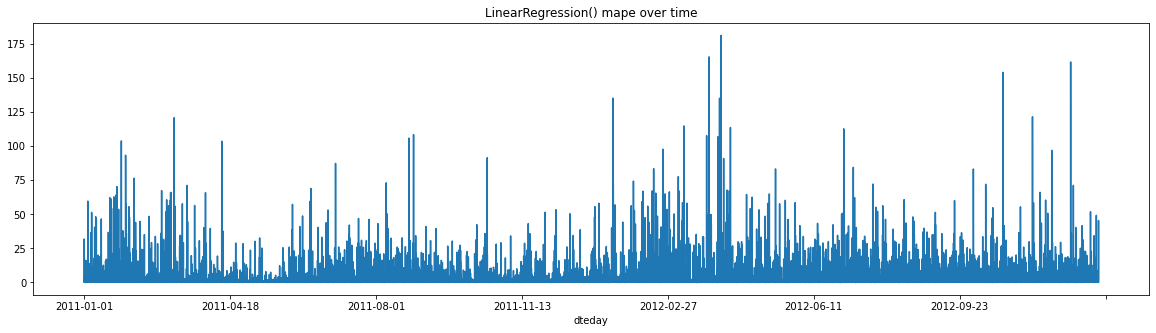

DecisionTreeRegressor() mape: 7.171322249121735e-05


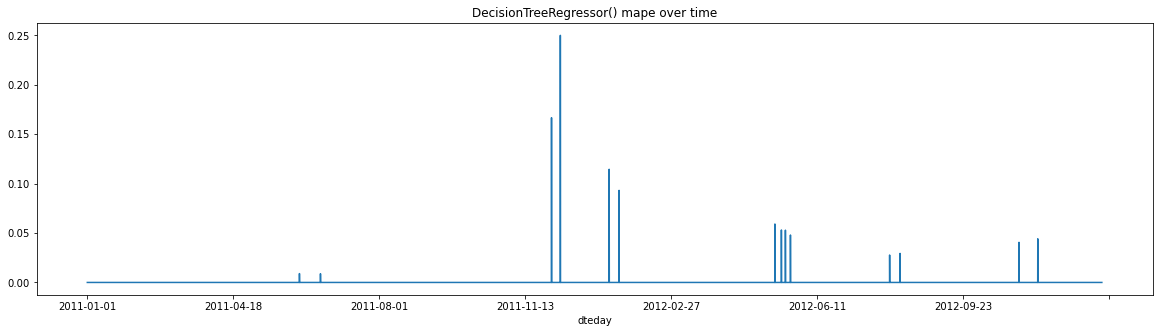

RandomForestRegressor(criterion='mae', max_depth=10, n_estimators=5,
                      random_state=42) mape: 0.2969863412382007


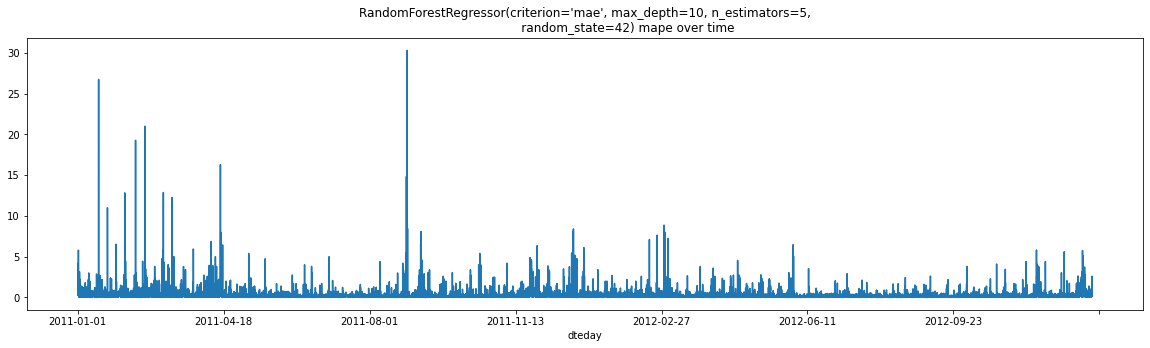

In [11]:
for model in [lr, dt, rf]:
    model_check = X_train.copy()
    model_check['cnt'] = y_train.copy()
    model_check = pd.merge(model_check, data['dteday'], how='left', left_index=True, right_index=True)

    model_check['yhat_lr'] = model.predict(X_train)
    model_check['mae'] = abs(model_check['yhat_lr'] - model_check['cnt'])
    model_check['mape'] = model_check['mae'] / model_check['cnt']

    print(f'{model} mape:', model_check['mape'].mean())
    
    model_check.sort_values(by='dteday').set_index('dteday')['mape'].plot(
    figsize=(20,5)
    , title=f'{model} mape over time')
    plt.show()

It's clear that LinearRegression have more than one problem in intercepting the actual trends, but so do random forests at time, with some points being way off. Unrestriced, unpruned trees show a dramatic overfitting.

Let's now build a function to perform cross validation on the set. We might expect:
- LR will be stable
- Trees might show swinging behavior, showing their tendency to overfit.
- Random forest, being an average of multiple trees, should keep a more stable behavior.

In [12]:
def cross_validate(data, target, model_labels, models):
    results = {}
    for label, mod in zip(model_labels, models):
    # cross validating mean taking this implies multiple fitting, so random forests will take a while
        scores = cross_val_score(mod, data, target, scoring='neg_mean_squared_error', cv=5)
        rmses = np.sqrt(abs(scores))
        mean_rmses = rmses.mean()
        detail={'folds_rmses':rmses, 'Mean rmse':mean_rmses}
        results[label] = detail
    return results       

cv = cross_validate(X_train, y_train, model_labels=['lr','dt', 'rf'], models=[lr, dt, rf])    
cv

{'lr': {'folds_rmses': array([139.24727653, 143.42905459, 140.06360974, 147.02722352,
         142.95650049]),
  'Mean rmse': 142.5447329740914},
 'dt': {'folds_rmses': array([63.36758924, 60.57884215, 61.24583365, 60.96391933, 65.13432717]),
  'Mean rmse': 62.258102309066125},
 'rf': {'folds_rmses': array([56.6311883 , 61.5574694 , 54.77154462, 58.55125729, 57.72284475]),
  'Mean rmse': 57.84686087185669}}

Trees seem to work suprisingly well, and cross validation, evalutaed on RMSE, does not show a worrying behavior. Nevertheless, Random forests still look like a better solution.

# Iteration 2
Let's now try a more serious feature engineering, where we will transform categorical features with proper encoding.

In [13]:
data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

By one-hot encoding variables, we can get multiple columns with values 1-0. From two columns with a total of 11 different values, we get a grand total of 11 columns across all the dataset. These get specific column names.

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

encode_test = ['weekday', 'weathersit']
cat_encoder = OneHotEncoder()
print(cat_encoder.fit_transform(X_train[encode_test]).shape)
cat_encoder.categories_

(13903, 11)


[array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([1, 2, 3, 4], dtype=int64)]

Cool, we shall now implement a function that will
- define a `time_label` feature, converting `hr` in a string reference
- One-Hot Encode three features: `weekday`, `weathersit`, `time_label`
The one-hot encoding is done to remove numeric variables that have no meaning per se (e.g. in weathersit, it makes no sense to say that storms are 4 times a sunny day (1); also, it will be performed through a `ColumnTransformer` object for reproducibility.

In [15]:
cat_features = [
    'weekday',    # 0-6 
    'time_label', # time_label is a 1-4 transformation of hour
    'weathersit'  # 1-4, each related to more serious weather conditions
]

In [16]:
def assign_label(hour):
    if hour >=0 and hour < 6:
        return 'night'
    elif hour >=6 and hour < 12:
        return 'morning'
    elif hour >= 12 and hour < 18:
        return 'afternoon'
    elif hour >= 18 and hour <=24:
        return 'evening'


def enrich_and_pipe(df_original, cat_columns, return_df=True):
    df = df_original.copy()
    # define the string version time_label
    df['time_label'] = df['hr'].apply(assign_label)
    
    # ColumnTransformer can be used to encode Categorical columns as well as keeping all the others still
    processor = ColumnTransformer([
        ('cat', OneHotEncoder(), cat_columns)
    ], remainder='passthrough') # passthrough as a parameter is needed, otherwise unexplicited cols get dropped
    
    # call fit_trasnform on the ColumnTransformer ang get an encoded version of the cat_columns
    output = processor.fit_transform(df)
    print('The encoded dataset has shape: ', output.shape)
    output_cols = processor.get_feature_names() # method of ColumnTransformer, that generates the feature names
    # horrifying way of cleaning the generated columns through the .get_feature_names method
    cleaned_cols = [col.replace('cat__x0', 'workday').replace(r'cat__x1_','').replace('cat__x2_','weather_')
                    for col in output_cols]
    if return_df:
        output = pd.DataFrame(output, 
                              columns = cleaned_cols, 
                              index=df.index) # VERY important to keep things aligned
    return output

X_train_rich = enrich_and_pipe(X_train,
                       cat_columns=cat_features,
                       return_df=True)

X_train_rich.columns

The encoded dataset has shape:  (13903, 25)


Index(['workday_0', 'workday_1', 'workday_2', 'workday_3', 'workday_4',
       'workday_5', 'workday_6', 'afternoon', 'evening', 'morning', 'night',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'season', 'yr',
       'mnth', 'hr', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed'],
      dtype='object')

----
Let's now retrain the models with the enhanced feature set.

In [17]:
for mod in [lr, dt, rf]:
    mod.fit(X_train_rich, y_train)

In [18]:
model_summary_iteration2 = model_summary_metrics(model_labels=['lr', 'dt', 'rf']
                      , fitted_models=[lr, dt, rf]
                      , data=X_train_rich
                      , target=y_train)
model_summary_iteration2

{'lr': {'mae': 96.87309557738828,
  'mape': 3.06,
  'rmse': 129.1199368866656,
  'r2-score': 0.4978616999571601},
 'dt': {'mae': 0.015032726749622383,
  'mape': 0.0,
  'rmse': 0.5989453436724405,
  'r2-score': 0.999989195339537},
 'rf': {'mae': 29.754671653599942,
  'mape': 0.29,
  'rmse': 50.42986910745093,
  'r2-score': 0.923402883724576}}

In [19]:
cv_iteration2 = cross_validate(X_train_rich
                               , y_train
                               , model_labels=['lr','dt', 'rf']
                               , models=[lr, dt, rf])    
cv_iteration2

{'lr': {'folds_rmses': array([126.73890981, 129.77312228, 128.24431599, 132.13110899,
         129.87501913]),
  'Mean rmse': 129.35249523748357},
 'dt': {'folds_rmses': array([60.7967949 , 61.67680024, 58.51003596, 60.52192584, 64.178329  ]),
  'Mean rmse': 61.136777187324086},
 'rf': {'folds_rmses': array([56.67514037, 61.95017491, 54.55016419, 58.71411992, 58.0293454 ]),
  'Mean rmse': 57.98378895775204}}

The feature engineering work has brought some improvement mostly on the linear model; this can be explained by the fact that by one-hot encoding features, we remove the concept of linearity in the numerical relationships (e.g. in weathersit, it makes no sense to say that storms are 4 times a sunny day (1).

# Iteration 3
Model tuning for best parameters, will be done for Random Forests. 
To avoid investing too much time in the operation, we will use a `RandomizedSearchCV`. An excellent extract is taken from this article on [TowardsDataScience](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74), credits to the author.

In [20]:
X_train_rich.shape

(13903, 25)

In [21]:
from sklearn.model_selection import RandomizedSearchCV

clean_forest = RandomForestRegressor()

param_grid = [
    {'n_estimators': [5, 10, 30, 50]
    , 'max_features': [5,10,15,25]
    , 'min_samples_leaf': [2,5,10]
    , 'min_samples_split': [2,5,10]
    , 'max_depth': [i for i in range(10,110,10)]
    , 'bootstrap': [True, False]
    }
]

In [22]:
rf_random = RandomizedSearchCV(estimator = clean_forest
                               , param_distributions = param_grid
                               , n_iter = 20 # go through 20 different random combinations
                               , cv = 3      # cross validate 3 times
                               , verbose = 2
                               , random_state = 42
                               , n_jobs = -1)

rf_random.fit(X_train_rich, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions=[{'bootstrap': [True, False],
                                         'max_depth': [10, 20, 30, 40, 50, 60,
                                                       70, 80, 90, 100],
                                         'max_features': [5, 10, 15, 25],
                                         'min_samples_leaf': [2, 5, 10],
                                         'min_samples_split': [2, 5, 10],
                                         'n_estimators': [5, 10, 30, 50]}],
                   random_state=42, verbose=2)

In [23]:
optimal_grid = rf_random.best_params_
print(optimal_grid)

{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 15, 'max_depth': 70, 'bootstrap': False}


We can retest the hyperparameter-tuned model on the Training set, and then apply it to the test set, which is something we have set aside from the very beginning, so that no data leakage is possible.
In order to work on the test set, we need to:
- run `enrich_and_pipe` function on `X_test`, so to get the enriched dataframe with OneHotEncoded columns.
- Fit `best_forest` with `X_test_rich` 
- Get model score and use `predict` method.
- Compare if the standard RandomForestRegressor performs better / worse compared to the tuned version (hopefully worse!)

In [24]:
best_forest = RandomForestRegressor().set_params(**optimal_grid)
best_forest.fit(X_train_rich, y_train)

bf = model_summary_metrics(model_labels=['best_forest']
                      , fitted_models=[best_forest]
                      , data=X_train_rich
                      , target=y_train)
bf

{'best_forest': {'mae': 17.10277191925968,
  'mape': 0.2,
  'rmse': 28.345581838852148,
  'r2-score': 0.9758004388767416}}

In [25]:
X_test_rich = enrich_and_pipe(X_test,
                           cat_columns=cat_features,
                           return_df=True)

print('Best_forest r2 score on Test set: ', best_forest.score(X_test_rich, y_test), '\n'
      'First_forest r2 score on Test set:', rf.score(X_test_rich, y_test), '\n'
      'Decision_Tree r2 score on Test set:', dt.score(X_test_rich, y_test)
     )

The encoded dataset has shape:  (3476, 25)
Best_forest r2 score on Test set:  0.9412664111829372 
First_forest r2 score on Test set: 0.9010714393962325 
Decision_Tree r2 score on Test set: 0.8911416698896122


Good job! We got a 4% improvement on model predictions by tweaking the hyperparameters.

---
# Feature importance and model explanation
One of the notorious trade-offs in the field is the trade off between model complexity and interpretability. Random Forests are tipically strong performers but obscure to interpret. In order to break this symmetry, we can try to get two different levels of understanding:  
- Feature importance (which features hold most predictive power?)
- Shapley Values (a game-theoretic approach that aims to explain complex models)

First approach is to get the feature importance with the RF built-in method, the MDI (Mean decrease in impurity). There are a number of limitations here given the risk of model overfit (random forests are models that can intercept trends in , but this can be solved via permutation importance.

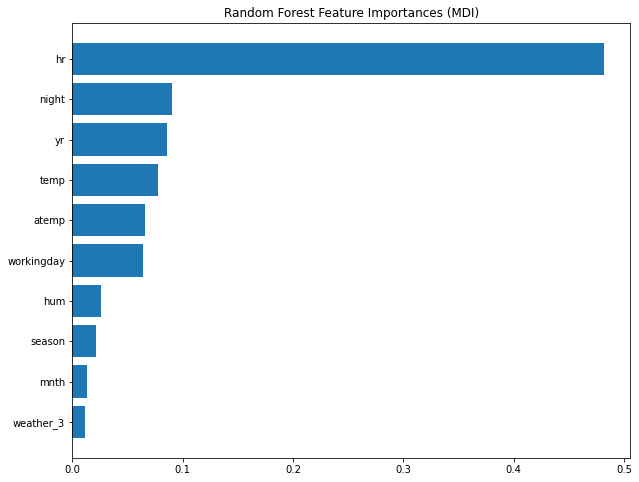

In [26]:
def plot_feature_importance(model=best_forest, dataset=X_train_rich, top_n=10):
    importances = model.feature_importances_
    feature_names = dataset.columns
    
    # define a series
    s = pd.Series(importances, index=feature_names).sort_values()
    s2 = s[-top_n:]
    fig, ax = plt.subplots(figsize=(10,8))
    ax.barh(s2.index, s2.values)
    ax.set_title("Random Forest Feature Importances (MDI)")
    plt.show()

plot_feature_importance(model=best_forest, dataset=X_train_rich, top_n=10)  

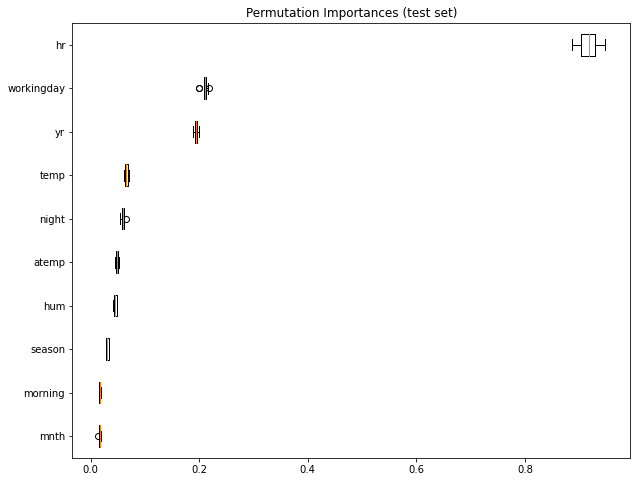

In [27]:
from sklearn.inspection import permutation_importance

def permutation_feature_importance(model, dataset, target, top_n=10):
    result = permutation_importance(model, dataset, target, n_repeats=10,
                                    random_state=seed, n_jobs=2)
    sorted_idx = result.importances_mean.argsort() #this will return an array of integers, where the int value is the relative importance of the feature
    sorted_cols = dataset.columns[sorted_idx] #return a list of columns ordered from 0 (less important) to dataset.shape[0] (most important)

    fig, ax = plt.subplots(figsize=(10,8))
    ax.boxplot(result.importances[sorted_idx][-top_n:].T,
               vert=False, labels=sorted_cols[-top_n:])
    ax.set_title("Permutation Importances (test set)")
    plt.show()
    
    return result

perm_imp = permutation_feature_importance(model=best_forest, 
                                          dataset=X_test_rich,
                                          target=y_test,
                                          top_n=10)

The result here shows that while `hr` maintains its first rank as a main explanatory variable, temperature decreases to fouth position, creating a stronger "step" between the top 3 variables and the following ones. So the main outcome here is that **permutation feature importance helps us understand how worse the algorithm is going to get by each feature we exclude**: kick out `[hr, working,day, year]` and the whole algo will drop substantially its accuracy.  

---
# SHAP for model explainability
The remaining item we want to explore is related to model explainability, both in terms of **local** predictions (why a certain prediction value is X? how do  the various features contribute to this?) and **global** interpetability (what is the Random Forest doing "under the hood"?). One of the state of the art methods to get these answers is SHAP.

In [28]:
import shap
shap.initjs()

In [29]:
# Given the computational expense, we will sample only to 1000 cases of the training set, defining a sample
sample = X_train_rich.sample(1000, random_state=seed)

# take the trained model of choice -  and feed it to shap.Explainer alongside the data sample
# at last, calculate Shapley values accordingly on that sample.
explainer = shap.TreeExplainer(best_forest, sample)
shap_values = explainer(sample)

 96%|=================== | 955/1000 [00:20<00:00]       

In [30]:
shap_values.base_values[0]

180.93642984876232

In [31]:
# shouldn't this be equal to shap_values.base_value? 
# could be linked to https://github.com/slundberg/shap/issues/1810
print('average best_forest prediction on sample:', np.mean(best_forest.predict(sample)))
print('base_value of SHAP (the model ouputput with no feature knowledge):', shap_values.base_values.mean())

average best_forest prediction on sample: 191.90754572129018
base_value of SHAP (the model ouputput with no feature knowledge): 180.9364298487623


In [32]:
#best_forest.fit(X_train_rich, y_train)

print('\x1b[1m{:8>}  {:>9}  {:>9}  {:>9}  {:>9}\x1b[0m'.format('n_sample', 'expected', 'base_val', 'avg_pred', 'the_same'))
for n_sample in [10, 30, 60, 90, 110, 1000]: #range(10, 150, 20):

    # Build explainer with background data of a certain size:    
    X_sample = X_train_rich.sample(n_sample, random_state=seed)
    explainer = shap.TreeExplainer(best_forest, data=X_sample)

    # Get base value (should be the expectation value of the model's predictions):
    base_value = explainer(X_sample).base_values[0]
    exp_value  = explainer.expected_value

    # Compute the expectation value of model's predictions directly:
    y_sample_pred = best_forest.predict(X_sample)
    avg_pred = np.mean(y_sample_pred)

    # Compare both:
    print('{:8d}  {:9.5f}  {:9.5f}  {:9.5f}  {:>9}'.format(n_sample, exp_value, base_value, avg_pred, str(np.isclose(base_value, avg_pred))))

n_sample   expected   base_val   avg_pred   the_same
      10  143.60762  143.60762  143.60762       True
      30  155.64719  155.64719  155.64719       True
      60  179.86715  179.86715  179.86715       True
      90  186.25671  186.25671  186.25671       True
     110  197.37487  197.37487  205.57469      False


 97%|=================== | 969/1000 [00:21<00:00]       

    1000  180.93643  180.93643  191.90755      False


# Global interpretation
Here we get something conceptually similar to what we were looking at in the permutation importance graph. How much, on average, each feature is contributing in this regression problem, based on the fitted model we used as a choice, `best_forest`.

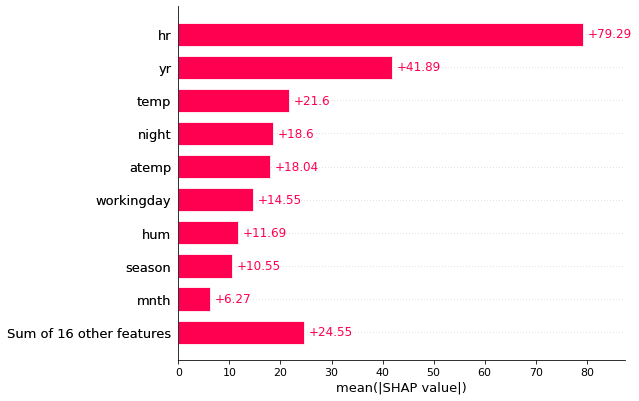

In [33]:
shap.plots.bar(shap_values)

The result here are pretty in line with what we had before (except for the sorting), but to get the gist of what is happening, we can look at specific predictions to better explain what is happening in these aggregated mean SHAP values contributions.

# Local interpretability of SHAP values
Given a set of model predictions, how do the features contribute in getting to that specific point?

In [34]:
sample['predictions'] = best_forest.predict(sample)
sample.iloc[:5,-1:]

,predictions
10801,7.078508
1636,190.721254
16571,36.935437
16370,242.580786
13196,17.014119


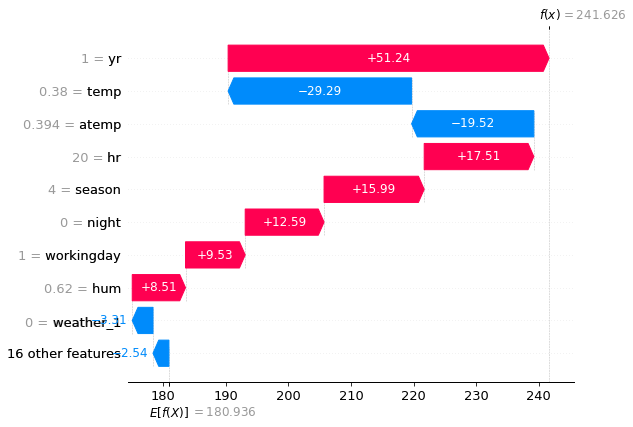

In [41]:
shap.plots.waterfall(shap_values[3], max_display=10)

In [42]:
shap.plots.force(shap_values[3])

And, on a more generic term, with the beeswarm plot we can  better understand the relationships for each single observation (1 point = 1 row) related to the features; according to the feature value (high/low) and its position in the plot. 
A very easy one to interpret is `yr` (that is a categorical variable, 0/1, where 1 is 2012, where more rentals are registered all over the way). When the feature is high (the year is 2012), the predictions are always higher vs when the feature is low (the year is 2011).

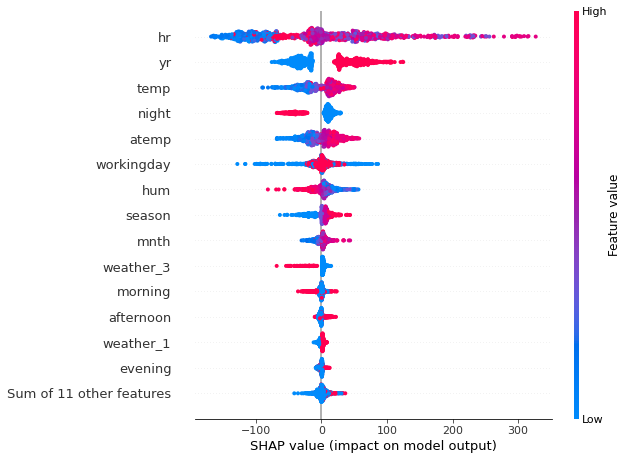

In [37]:
shap.plots.beeswarm(shap_values, max_display=15)

# Dependency plots
Dependency plots are an excellent tool to spot trends between feature values and feature shapley values (as a measure of the regressive importance), especially when cross-references with other variables to spot the relationships among them.
The following one is a great example showing which values of `hr` have an inluence in predicting the. has an influence in predicting the mean
- during **working days**, (red dots), there are two very obvious peaks at `hr` values of 7-8, and 17-19 - that is, when people go to the office and come back home. Alas, this means that when the values of `hr` are in these timebands, we will get a higher predicted value of rented bikes.
- during **festive days** (blue dots) instead, the relationship is not quite as strong, with a more evenly distributed usage of bikes during day hours.

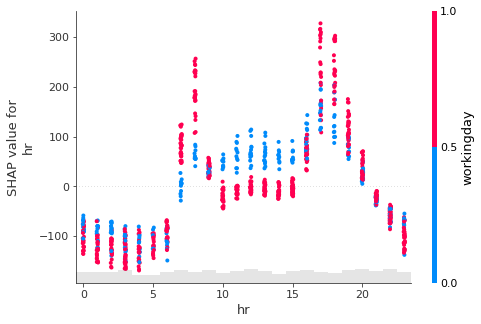

In [38]:
shap.plots.scatter(shap_values[:, "hr"], color = shap_values)#, color=shap_values[:,"yr"])

With a simple loop we can look for multiple relations all at once.

NameError: name 'math' is not defined

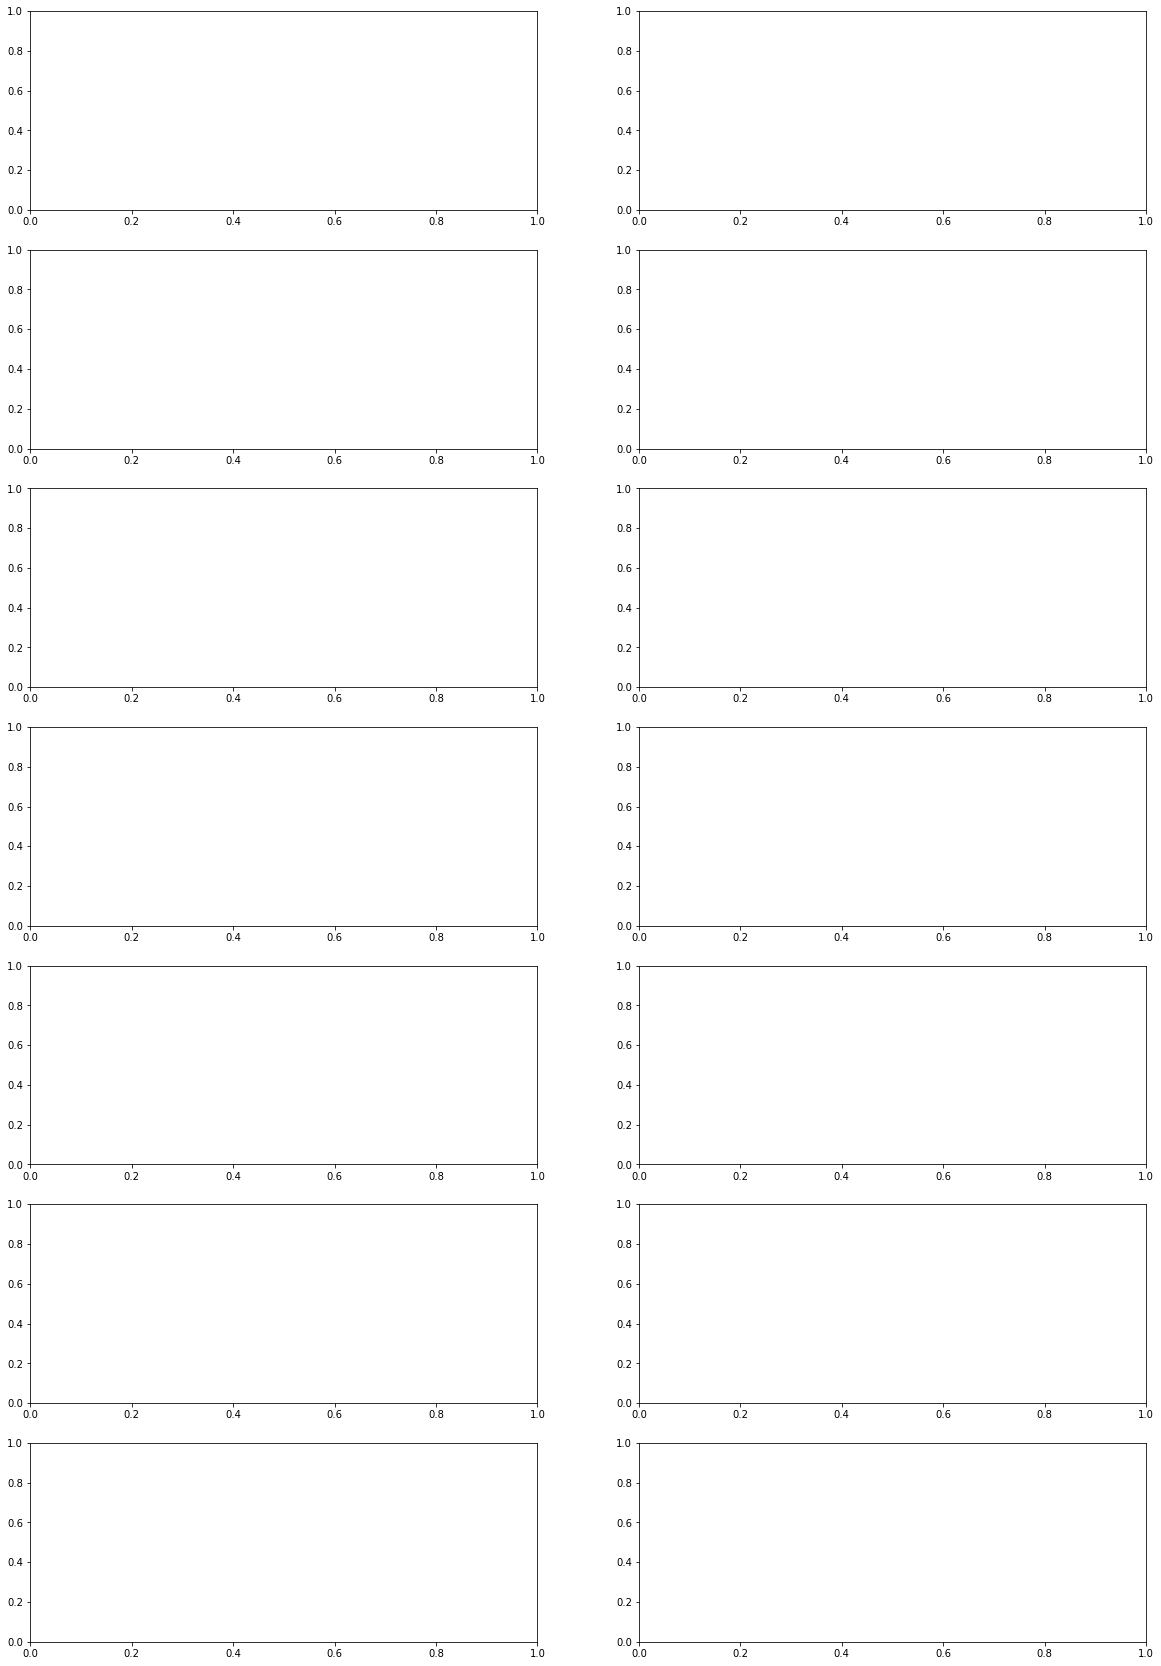

In [39]:
to_inspect = X_test_rich.columns[~X_test_rich.columns.str.contains('_')]

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 30))
helper = [0,1]*7
for idx, feature in enumerate(to_inspect):
    true_idx = math.floor(idx/2)
    shap.plots.scatter(shap_values[:, feature], 
                       ax=axes[true_idx,      # true idx manags the rows, and is [0,0,1,1,2,2,...,6,6]
                               helper[idx]],   # helper bounces back and forth in a sequence of [0,1,0,1,0,1], addressing the right column
                       show=False, color = shap_values)#, color=shap_values[:,"yr"])